In [4]:
import xgboost as xgb
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
import numpy as np

In [30]:
# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

# Filter out the classes for binary classification of digits 0 and 1
mask = (mnist.target == '0') | (mnist.target == '1')
X_mnist, y_mnist = mnist.data[mask], mnist.target[mask].astype(int)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_mnist, y_mnist, test_size=0.2, random_state=42)

c:\Repository\TreeNeuralAnsatz\env\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [33]:
np.std(X_train.to_numpy())

76.64858090034015

In [34]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

In [35]:
np.std(X_train)

0.8842441716528543

In [14]:
# X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [16]:
# Train an XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [17]:
xgb_clf.score(X_test, y_test)

0.9996617050067659

In [18]:
def approximate_gradient(mdl, x: np.array, y: int, n_iters:int, std:int):
    delta_x = 0
    variance = std**2
    # iterate over each data point
    for i in range(n_iters):

        # get new epsilon
        epsilon = np.random.normal(scale=std, size=x.shape[0])

        # perturb the data point
        p = x + epsilon
    
        # get the new prediction
        new_pred = mdl.predict(p[np.newaxis, :])
    
        # get residual
        residual = new_pred - y

        # calculate the delta
        delta_x += (residual * epsilon) / variance
    
    # take the average
    delta_x /= n_iters

    return delta_x

def calculate_AGOP(mdl, X: np.array, Y:np.array, n_iters:int, std:int):
    AGOP = np.zeros(shape=(X.shape[1], X.shape[1]))
    # iterate over all data points
    for i in range(X.shape[0]):
        x = X[i]
        y = Y[i]

        # get the approximate gradient
        grad = approximate_gradient(mdl, x, y, n_iters, std)

        # take the outer product (gradient outer product)
        GOP = np.outer(grad, grad)

        # add that to the current GOP
        AGOP += GOP

        if i % 500 == 0:
            print(f"Finished: {i+1}/{X.shape[0]}")
    
    # take the average over all datapoints
    AGOP = AGOP / X.shape[0]
    return AGOP

In [21]:
AGOP = calculate_AGOP(xgb_clf, X_train, y_train, n_iters=2000, std=0.88)

Finished: 1/11824
Finished: 501/11824
Finished: 1001/11824
Finished: 1501/11824
Finished: 2001/11824
Finished: 2501/11824
Finished: 3001/11824
Finished: 3501/11824
Finished: 4001/11824
Finished: 4501/11824
Finished: 5001/11824
Finished: 5501/11824
Finished: 6001/11824
Finished: 6501/11824
Finished: 7001/11824
Finished: 7501/11824
Finished: 8001/11824
Finished: 8501/11824
Finished: 9001/11824
Finished: 9501/11824
Finished: 10001/11824
Finished: 10501/11824
Finished: 11001/11824
Finished: 11501/11824


In [ ]:
with open('AGOPX.npy', 'wb') as f:
    np.save(f, AGOP)

# Check the Output of the AGOP calculations

In [41]:
agop_to_load = 'AGOP3.npy'

In [42]:
AGOP = np.load(agop_to_load)

In [43]:
AGOP

array([[ 7.02282383e-05, -4.49479430e-07, -1.23972504e-07, ...,
        -6.91198449e-07,  1.23983584e-06, -2.24028978e-06],
       [-4.49479430e-07,  7.45530887e-05,  2.31845045e-06, ...,
         6.39294218e-07,  2.82278734e-08, -6.76717240e-07],
       [-1.23972504e-07,  2.31845045e-06,  7.21390705e-05, ...,
         9.49449129e-07, -1.23521766e-06,  1.23963243e-06],
       ...,
       [-6.91198449e-07,  6.39294218e-07,  9.49449129e-07, ...,
         7.12799713e-05, -2.06216438e-07, -5.63214178e-07],
       [ 1.23983584e-06,  2.82278734e-08, -1.23521766e-06, ...,
        -2.06216438e-07,  6.96396440e-05,  5.44548019e-07],
       [-2.24028978e-06, -6.76717240e-07,  1.23963243e-06, ...,
        -5.63214178e-07,  5.44548019e-07,  7.31629566e-05]])

In [44]:
import matplotlib.pyplot as plt

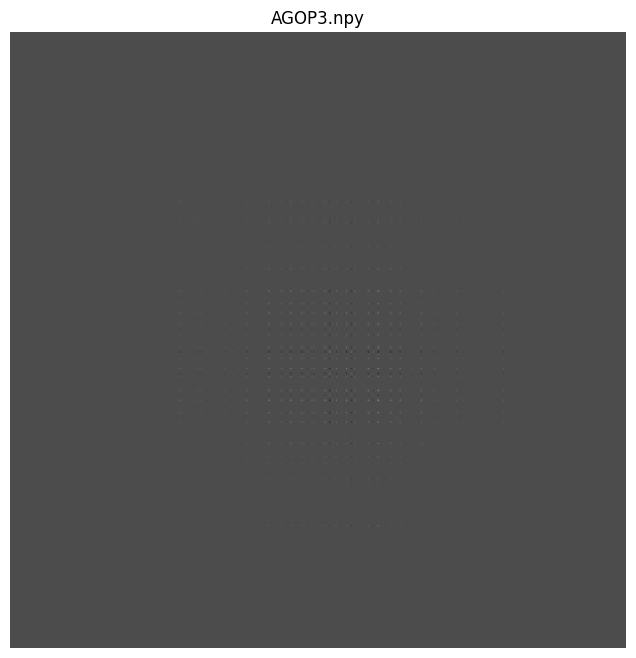

In [45]:
normalized_array = (AGOP - np.min(AGOP)) / (np.max(AGOP) - np.min(AGOP))

# Plot the image
plt.figure(figsize=(8, 8))
plt.imshow(normalized_array, cmap='gray')
plt.title(agop_to_load)
plt.axis('off')
plt.show()